Yash Kumar Chandak

22070126134

AIML B3

In [ ]:
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
dataroot = "/kaggle/input/celeba-dataset"

In [ ]:
# Hyperparameters
batch_size = 128
image_size = 64
nc = 3  # Number of channels (RGB)
nz = 100  # Size of the latent vector
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
num_epochs = 10
lr = 0.0002
beta1 = 0.5
ngpu = 1  # Number of GPUs to use

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(root=dataroot, transform=transform)

In [ ]:
# Use only 10% of the dataset
total_size = len(dataset)
subset_size = int(0.1 * total_size)
indices = random.sample(range(total_size), subset_size)
subset = Subset(dataset, indices)

dataloader = data.DataLoader(subset, batch_size=batch_size, shuffle=True)

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Initialize networks
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):
        ## Update Discriminator: Maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()

        # Train with real images
        real_data = data.to(device)
        label = torch.full((data.size(0),), 1, dtype=torch.float, device=device)  # Ensure label is float
        output = netD(real_data).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(data.size(0), nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0)  # Reset labels for fake data
        label = label.to(dtype=torch.float)  # Ensure dtype is float
        output = netD(fake_data.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        ## Update Generator: Maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(1)  # Reset labels for generator training
        label = label.to(dtype=torch.float)  # Ensure dtype is float
        output = netD(fake_data).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] Loss D: {lossD_real+lossD_fake:.4f}, Loss G: {lossG:.4f}")

Epoch [0/10] Step [0/159] Loss D: 0.5989, Loss G: 3.9415
Epoch [0/10] Step [100/159] Loss D: 0.6298, Loss G: 5.2353
Epoch [1/10] Step [0/159] Loss D: 0.9823, Loss G: 3.5165
Epoch [1/10] Step [100/159] Loss D: 0.6067, Loss G: 2.2847
Epoch [2/10] Step [0/159] Loss D: 0.6098, Loss G: 4.6089
Epoch [2/10] Step [100/159] Loss D: 0.9971, Loss G: 5.8267
Epoch [3/10] Step [0/159] Loss D: 1.5398, Loss G: 1.5710
Epoch [3/10] Step [100/159] Loss D: 0.4557, Loss G: 5.0419
Epoch [4/10] Step [0/159] Loss D: 0.3867, Loss G: 4.1436
Epoch [4/10] Step [100/159] Loss D: 0.8427, Loss G: 2.3216
Epoch [5/10] Step [0/159] Loss D: 0.6225, Loss G: 1.6820
Epoch [5/10] Step [100/159] Loss D: 0.3131, Loss G: 4.0114
Epoch [6/10] Step [0/159] Loss D: 1.0541, Loss G: 6.3120
Epoch [6/10] Step [100/159] Loss D: 0.4831, Loss G: 2.4453
Epoch [7/10] Step [0/159] Loss D: 0.6156, Loss G: 1.7831
Epoch [7/10] Step [100/159] Loss D: 0.4306, Loss G: 3.6336
Epoch [8/10] Step [0/159] Loss D: 0.6876, Loss G: 4.2881
Epoch [8/10] St

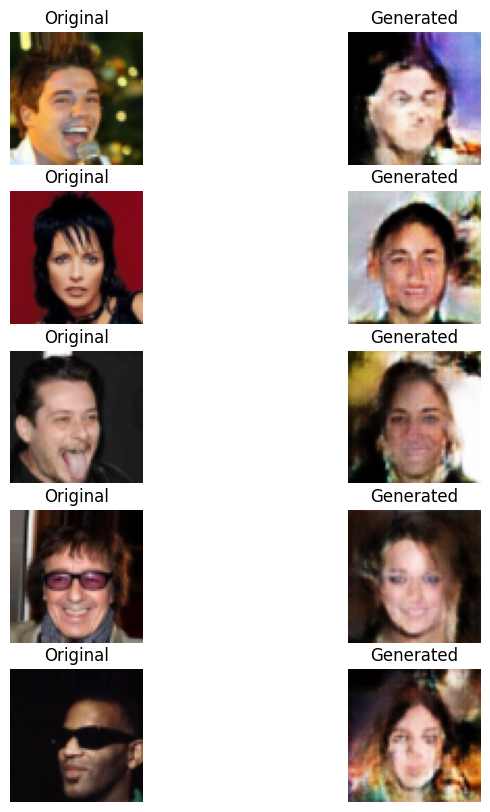

In [ ]:
# Display original and generated images
real_images, _ = next(iter(dataloader))
real_images = real_images[:5]

with torch.no_grad():
    fake_images = netG(torch.randn(5, nz, 1, 1, device=device)).cpu()

fig, axes = plt.subplots(5, 2, figsize=(8, 10))
for i in range(5):
    axes[i, 0].imshow(np.transpose(real_images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Generated")

plt.show()